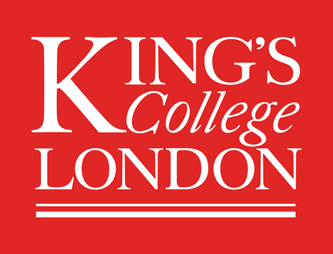


# Coursework Assignment #2

---

## King's College London

---

**Course Title**: Computational Finance MSc

**Module Name**: High-Frequency Finance

**Module Code**: 7CCSMHFF

**Module Leaders**: Dr Teresa Yu Bi and Prof. Carmine Ventre

**Student's Full Name**: Edmond Osmena

**Student ID**: K24034176

**Candidate Number**: AF15292

---
# <span style="color:blue"> Table of Contents </span>
[Introduction](#Introduction)  
[Part I: Trading strategy ](#Part-1)  
    1.1 [Import Libraries](#libraries)  
    1.2 [Data Loading and Exploration](#loading)  
    1.3 [Data Preprocessing](#preprocessing)  
    1.4 [Feature Engineering](#features)  
    1.5 [Data Validation](#validation)  
    1.6 [Data Analysis](#analysis)   
    1.7 [Implementation of Instrict Time Framework Strategy](#strategy)   
[Part II: Testing your strategy](#Part-2)  
[Results and Discussion](#RnD)  
[Conclusion](#Conclusion)  
[References](#References)

-----

# **<span style="color:blue">Introduction</span>** <a id="Introduction"></a>

This Jupyter Notebook is part of the **High-Frequency Finance** coursework, focusing on developing and testing a trading strategy on directional change. Within the report there will be Python scripting, comments within the code snipets but also explanation on markdowns. The report is structured into three parts:

1. **Trading Strategy** – Loading the data, conducting data exploration, performing data analysis and implementing a strategy based on instrict time and directional changes.  
2. **Testing your Strategy** – Backtesting the strategy and illustrating statistical results.  
3. **Results and Discussion** – Brief summary and discussion of the results.

To achieve this, the notebook includes textual explanations, screenshots, and Python code with its output where needed.

-------

# **<span style="color:blue">Part I: Trading strategy </span>** <a id="Part-1"></a>

### 1.1 Import Libraries<a id="libraries"></a>
In the Python code below, all libraries used across this coursework have been imported in this section in order to keep the code clean and organized.

In [1]:
# Data analysis libraries
import pandas as pd 
import numpy as np
from datetime import datetime # To handle datetimes

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# To display multiple DFs at once
from IPython.display import display

### 1.2 Data Loading and Exploration<a id="loading"></a>
The data used in this project was sourced from [HistData.com](https://www.histdata.com/download-free-forex-data/), as recommended in the coursework specification. To ensure a comprehensive analysis, I opted for **high-frequency tick data** of Generic ASCII, which provides granular insights into market dynamics and price fluctuations. As per the coursework description, I have chosen to apply and test  the strategy on the following pairs (thus also prepare the data for these currency pairs):
1. **`CAN/JPY`**
2. **`EUR/USD`**
3. **`GBP/USD`**

In [2]:
# Read all CSVs and save them to variables
nzd_jpy = pd.read_csv("DAT_ASCII_NZDJPY_T_202411.csv") # NZD/JPY
eur_usd = pd.read_csv("DAT_ASCII_EURUSD_T_202501.csv") # EUR/USD
gbp_usd = pd.read_csv("DAT_ASCII_GBPUSD_T_202501.csv") # GBP/USD

### 1.3 Data Preprocessing <a id="preprocessing"></a>
During this stage, the data has to be prepared before the strategy is applied to it. There are several steps taken here such as:
1. **`Rename Columns`** &rarr; Renaming columns to have consistent and meaningful names, such as "Datetime", "ask_price" and "bid_price".
2. **`Datatetime Format`** &rarr; Formatting the datetime column to a standardized format that includes milliseconds (YYYY-MM-DD hh:mm:ss:mss).
3. **`Drop Not Needed Columns`** &rarr; Removing columns that contain a single value, which do not contribute to the analysis. This will also contribute helping to reduce the running time, thus faster analysis and results. This is crucial as we are analysing a HFT strategy.
4. **`Set Datetime Index`** &rarr; Set Datetime as an index to retrieve easily data but also reduce the data dimensionality.

All these steps have been efficiently performed within the `transform_dataframe()` function. This function will be applied to all three datasets, as their data structure and formatting are consistent.

In [3]:
def transform_dataframe(df):
    """
    Change Datetime format and set it as an index of the DataFrame. 
    Additionally, rename columns and drop columns with only 1 value.

    Parameters:
        df (pd.DataFrame): Input DataFrame with at least four columns.
    
    Returns:
        pd.DataFrame: Transformed DataFrame with formatted datetime column, 
                      renamed price columns, and without the last zero-filled column.
    """
    # Convert the first column to string format
    df.iloc[:, 0] = df.iloc[:, 0].astype(str)

    # Extract datetime (YYYY-MM-DD hh:mm:ss.mmm) from the first column
    df['Datetime'] = df.iloc[:, 0].apply(
        lambda x: datetime.strptime(x[:8], '%Y%m%d').strftime('%Y-%m-%d') + 
                  ' ' + x[9:11] + ':' + x[11:13] + ':' + x[13:15] + '.' + x[15:]
        )
    
    # Convert 'Datetime' column to datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S.%f')
    
    # Rename the next two columns as ask_price and bid_price
    df.rename(columns={df.columns[1]: 'ask_price', df.columns[2]: 'bid_price'}, inplace=True)
    
    # Drop the column if it contains only a single unique value
    for col in df.columns:
        if df[col].nunique() == 1:
            df.drop(col, axis=1, inplace=True)
    
    # Drop the original datetime column
    df.drop(columns=[df.columns[0]], inplace=True)
    
    # Set Datetime as the index
    df.set_index('Datetime', inplace=True)

    return df

### 1.4 Feature Engineering <a id="features"></a>
In the code below, there is a new column created that will be quite helpful for insights and analysis. The new column is the **`spread`** (difference between bid and ask).

In [4]:
def spread(df):
    """
    Calculates the spread between bid and ask prices and adds it as a new column.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'bid_price' and 'ask_price' columns.
        
    Returns:
        pd.DataFrame: DataFrame with an additional 'spread' column.
    """
    
    df['spread'] = df['bid_price'] - df['ask_price']
    return df

### 1.5 Data Validation  <a id="validation"></a>
Run a few data validation checks such as **`Null`** values, **`duplicate`** values and ensure that the **`data types`** are as expected for all the columns. After confirming that all the datasets have the expected data, apply the data preprocessing and feature engineering function and display a sample (head and tail) of the final datasets. For the data validation check, a new function has been created called `validate_data()` which takes one or more dataframes and returns insights regarding the validation check.

In [5]:
def validate_data(*dfs):
    """
    Validates one or more DataFrames by checking for duplicates, null values, data types, & unique values.

    Parameters:
        *dfs (pd.DataFrame): One or more DataFrames to be validated.
        show_stats (bool): Whether to display basic descriptive statistics.

    Returns:
        None
    """
    for i, df in enumerate(dfs):
        print(f"\nValidation Report for DataFrame {i+1}")
        print("" * 50)

        df = df.reset_index()

        # Unique Values in Columns (displayed at the top)
        unique_columns = [col for col in df.columns if df[col].nunique() == 1]
        if unique_columns:
            print(f"Columns with Single Unique Values ({len(unique_columns)}):")
            print(", ".join(unique_columns))
        else:
            print("Single Value Columns: 0")

        # Duplicates (including Datetime, ask_price, bid_price, and spread)
        duplicate_count = df.duplicated(subset=['Datetime', 'ask_price', 'bid_price', 'spread']).sum()
        if duplicate_count > 0:
            print(f"Duplicate Rows: {duplicate_count}")
            print(f"Indices of Duplicates: {df[df.duplicated(subset=['Datetime', 'ask_price', 'bid_price', 'spread'])].index.tolist()}")
        else:
            print("Duplicate Rows: 0")

        # Null Values
        null_count = df.isnull().sum().sum()
        if null_count > 0:
            print(f"Null Values: {null_count}")
            print("Columns with null values:")
            print(df.isnull().sum()[df.isnull().sum() > 0])
        else:
            print("Null Values: 0")

        # Data Types
        print("\nData Types:")
        print(df.dtypes)
        print("=" * 50)

In [8]:
# Apply data preprocessing and feature engineering on initial dataset
nzd_jpy_df = spread(transform_dataframe(nzd_jpy))
eur_usd_df = spread(transform_dataframe(eur_usd))
gbp_usd_df = spread(transform_dataframe(gbp_usd))

In [9]:
validate_data(nzd_jpy_df, eur_usd_df, gbp_usd_df)


Validation Report for DataFrame 1

Single Value Columns: 0
Duplicate Rows: 0
Null Values: 0

Data Types:
Datetime     datetime64[ns]
ask_price           float64
bid_price           float64
spread              float64
dtype: object

Validation Report for DataFrame 2

Single Value Columns: 0
Duplicate Rows: 0
Null Values: 0

Data Types:
Datetime     datetime64[ns]
ask_price           float64
bid_price           float64
spread              float64
dtype: object

Validation Report for DataFrame 3

Single Value Columns: 0
Duplicate Rows: 0
Null Values: 0

Data Types:
Datetime     datetime64[ns]
ask_price           float64
bid_price           float64
spread              float64
dtype: object


In [10]:
# Review the data
dfs = [nzd_jpy_df, eur_usd_df, gbp_usd_df]
names = ['NZD/JPY', 'EUR/USD', 'GBP/USD']

for name, df in zip(names, dfs):
    print(f"Data for {name}:")
    display(df)
    print("\n")

Data for NZD/JPY:


,ask_price,bid_price,spread
Datetime,,,
2024-11-01 00:00:00.880,91.222,91.229,0.007
2024-11-01 00:00:00.982,91.223,91.230,0.007
2024-11-01 00:00:01.185,91.224,91.231,0.007
2024-11-01 00:00:01.545,91.223,91.230,0.007
2024-11-01 00:00:01.697,91.225,91.231,0.006
...,...,...,...
2024-11-29 16:56:38.735,88.483,88.867,0.384
2024-11-29 16:56:39.188,88.483,88.866,0.383
2024-11-29 16:56:39.542,88.429,88.868,0.439




Data for EUR/USD:


,ask_price,bid_price,spread
Datetime,,,
2025-01-01 17:00:14.949,1.03510,1.03585,0.00075
2025-01-01 17:00:19.212,1.03514,1.03585,0.00071
2025-01-01 17:02:34.026,1.03514,1.03590,0.00076
2025-01-01 17:04:01.734,1.03514,1.03612,0.00098
2025-01-01 17:04:30.794,1.03507,1.03612,0.00105
...,...,...,...
2025-01-31 16:59:56.304,1.03599,1.03650,0.00051
2025-01-31 16:59:56.356,1.03599,1.03642,0.00043
2025-01-31 16:59:56.861,1.03603,1.03641,0.00038




Data for GBP/USD:


,ask_price,bid_price,spread
Datetime,,,
2025-01-01 17:01:34.857,1.25134,1.25236,0.00102
2025-01-01 17:01:38.819,1.25138,1.25236,0.00098
2025-01-01 17:02:05.545,1.25136,1.25236,0.00100
2025-01-01 17:04:20.239,1.25136,1.25236,0.00100
2025-01-01 17:04:32.938,1.25136,1.25218,0.00082
...,...,...,...
2025-01-31 16:59:51.738,1.23906,1.23973,0.00067
2025-01-31 16:59:52.644,1.23906,1.23983,0.00077
2025-01-31 16:59:55.375,1.23906,1.23973,0.00067


### 1.6 Data Analysis  <a id="analysis"></a>

In [11]:
def plot_spread(df, color='blue'):
    """
    Plots the spread over time with a dynamically calculated threshold (3 times the mean spread).
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'spread' and 'Datetime' columns.
        color (str): Color of the spread line in the plot.
    """
    # Calculate the threshold as 3 times the mean of the spread
    threshold = 3 * df['spread'].mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['spread'], label='Spread', color=color, linewidth=1)
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold (3 x Mean Spread: {threshold:.6f})')
    plt.title('Spread over Time with Dynamic Threshold (3x Mean)')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


def plot_spread_means(df, color):
    """
    Plots the mean spread per hour and per day as subplots (1 row, 2 columns).
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'spread' and 'Datetime' columns.
        color (str): Color of the plot lines and bars.
    """
    # Hourly Mean Calculation
    df['hour'] = pd.to_datetime(df.index).hour
    hourly_mean = df.groupby('hour')['spread'].mean()

    # Daily Mean Calculation
    df['date'] = pd.to_datetime(df.index).date
    daily_mean = df.groupby('date')['spread'].mean()

    # Create Subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Hourly Mean Spread
    axes[0].bar(hourly_mean.index, hourly_mean.values, color=color)
    axes[0].set_title('Mean Spread per Hour')
    axes[0].set_xlabel('Hour of the Day')
    axes[0].set_ylabel('Mean Spread')
    axes[0].set_xticks(range(0, 24))
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)

    # Plot Daily Mean Spread
    axes[1].plot(daily_mean.index, daily_mean.values, marker='o', linestyle='-', color=color)
    axes[1].set_title('Mean Spread per Day')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Mean Spread')
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # Format x-axis to show every 7th day
    axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=7))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(axes[1].get_xticklabels(), rotation=45)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

    
def analyze_spread(df, color, threshold=0.025):
    """
    Displays the mean spread, and combines displays hourly and daily plots.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'spread' and 'Datetime' columns.
        threshold (float): Threshold level for the spread plot.
    """
    # Average spread
    avg_spread = df['spread'].mean()
    print(f"Average Spread: {avg_spread:.6f}")
    
    #plot_spread(df, threshold)
    plot_spread_means(df, color)
    pass

NZD/JPY
Average Spread: 0.014642


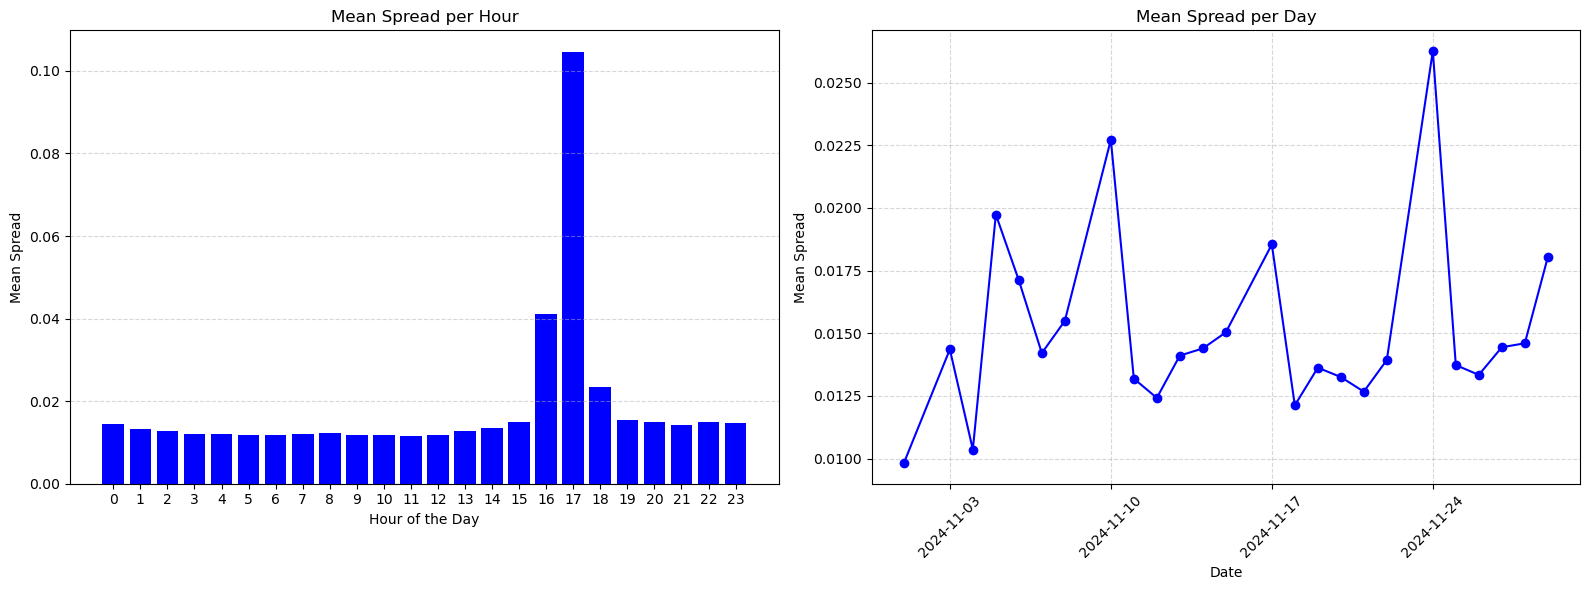


EUR/USD
Average Spread: 0.000034


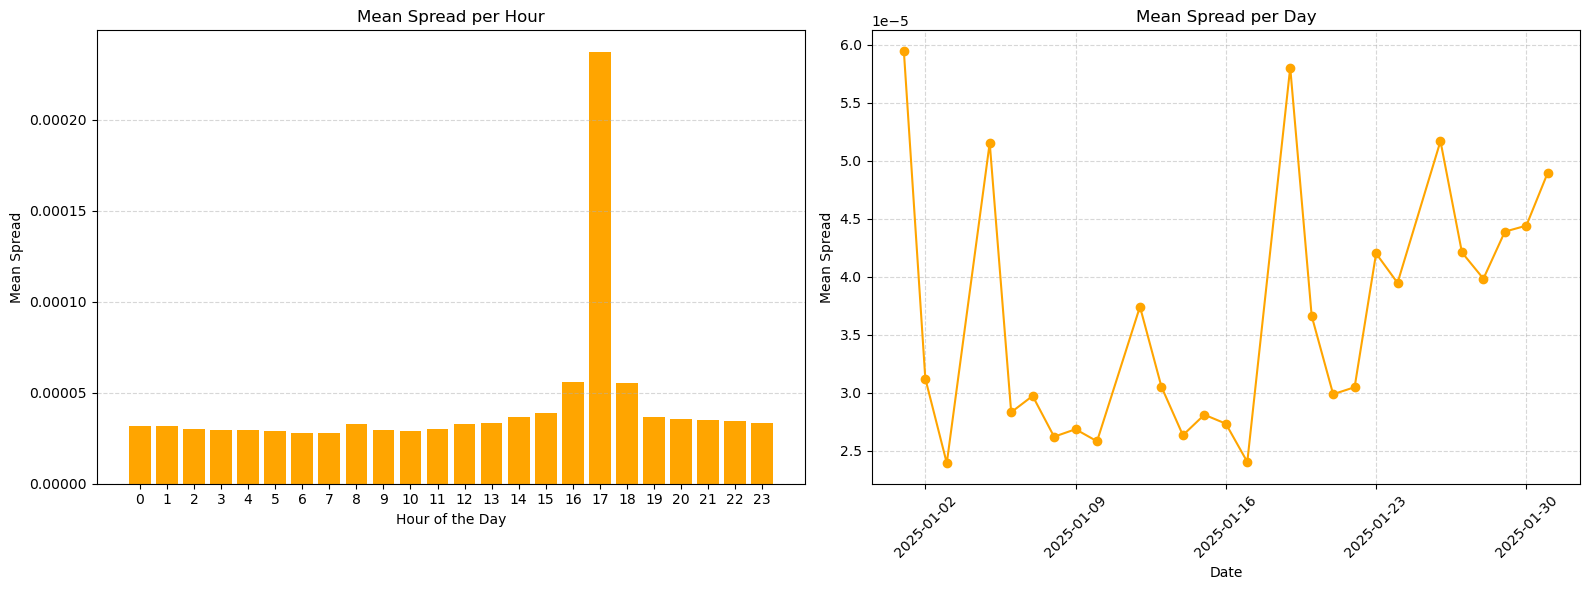


GBP/USD
Average Spread: 0.000099


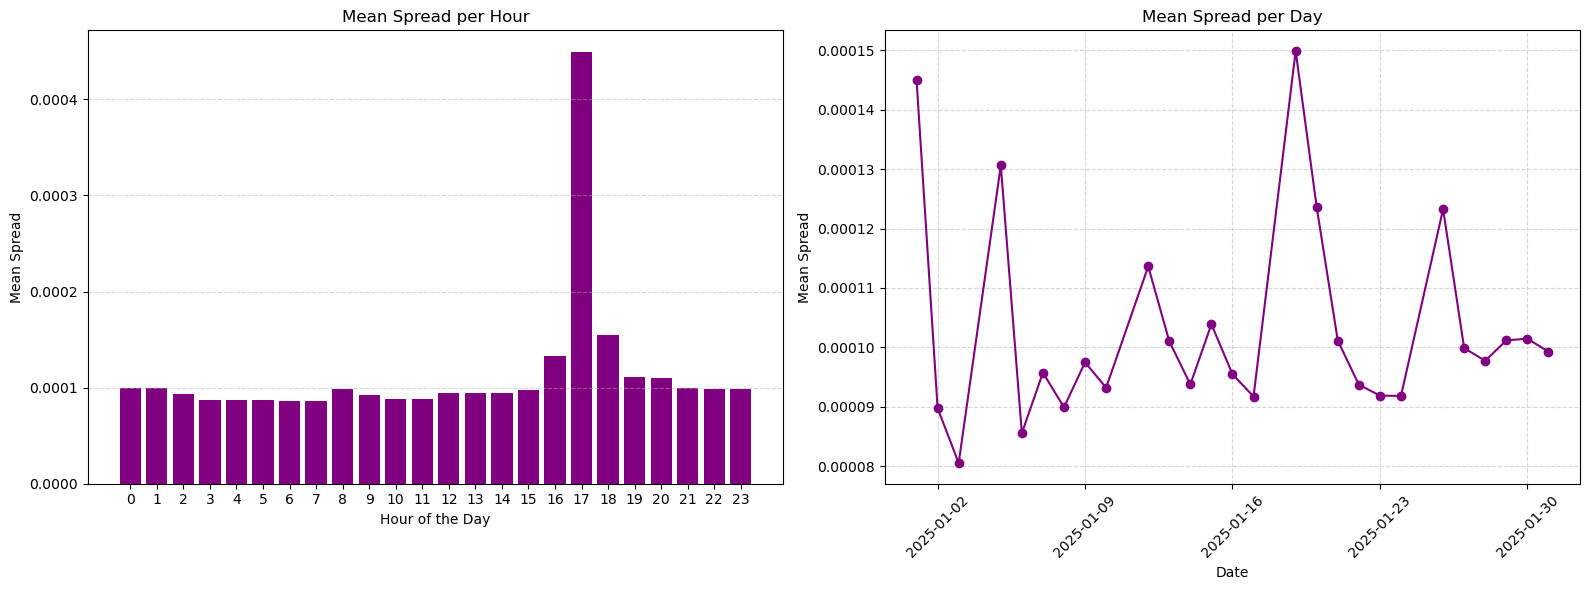

In [12]:
print("NZD/JPY")
analyze_spread(nzd_jpy_df, color="blue")

print("\nEUR/USD")
analyze_spread(eur_usd_df, color="orange")

print("\nGBP/USD")
analyze_spread(gbp_usd_df, color="purple")

### 1.7 Implementation of Instrict Time Framework Strategy  <a id="strategy"></a>

In [61]:
def intrinsic_event_detection(df, delta_up, delta_down):
    """
    Detects intrinsic events using the specified thresholds for upward and downward movements.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'spread' and 'Datetime' columns.
        delta_up (float): Upward movement threshold.
        delta_down (float): Downward movement threshold.

    Returns:
        events (list): A list of detected intrinsic events with timestamps and types.
    """
    events = []
    S_ext = S_IE = df['spread'].iloc[0]
    mode = None  # No initial direction

    for i in range(1, len(df)):
        S_tick = df['spread'].iloc[i]

        if mode is None:  # First tick
            S_ext = S_IE = S_tick
            events.append((df.index[i], 0))
            mode = 'up' if S_tick > S_ext else 'down'
            continue

        if mode == 'up':
            if S_tick - S_ext >= delta_up:
                mode = 'down'
                S_ext = S_tick
                S_IE = S_tick
                events.append((df.index[i], 1))
            elif S_tick < S_ext:
                S_ext = S_tick
                if S_IE - S_ext >= delta_down:
                    S_IE = S_tick
                    events.append((df.index[i], -2))
        elif mode == 'down':
            if S_ext - S_tick >= delta_down:
                mode = 'up'
                S_ext = S_tick
                S_IE = S_tick
                events.append((df.index[i], -1))
            elif S_tick > S_ext:
                S_ext = S_tick
                if S_ext - S_IE >= delta_up:
                    S_IE = S_tick
                    events.append((df.index[i], 2))
    return events


def visualize_intrinsic_events(df, events):
    """
    Visualizes the detected intrinsic events on the price movements.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing price data with Datetime as index.
        events (list): A list of detected intrinsic events with timestamps and types.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['ask_price'], label='Ask Price', color='blue', linewidth=1)
    plt.plot(df.index, df['bid_price'], label='Bid Price', color='orange', linewidth=1, alpha=0.5)
    # Format x-axis to show every 6th day and remove extra space
    plt.gca().set_xlim([df.index.min(), df.index.max()])
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.title('Intrinsic Events on Price Movements')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def backtest_trading_strategy(df, signals):
    """
    Backtests the trading strategy and provides performance metrics.

    Parameters:
        df (pd.DataFrame): DataFrame containing price and spread information.
        signals (list): List of trade signals with timestamps.

    Returns:
        dict: Performance metrics and statistics.
    """
    total_trades = len(signals)
    wins, losses = 0, 0
    largest_win, largest_loss = 0, 0
    total_return = 0
    hold_times = []

    for i in range(1, total_trades):
        entry_timestamp = signals[i-1][0]
        exit_timestamp = signals[i][0]

        entry_price = df.loc[entry_timestamp, 'ask_price']
        exit_price = df.loc[exit_timestamp, 'bid_price']
        pnl = (exit_price - entry_price) / entry_price
        total_return += pnl

        if pnl > 0:
            wins += 1
            largest_win = max(largest_win, pnl)
        else:
            losses += 1
            largest_loss = min(largest_loss, pnl)

        hold_time = (exit_timestamp - entry_timestamp).total_seconds() * 1000
        hold_times.append(hold_time)

    win_ratio = wins / total_trades if total_trades > 0 else 0
    shortest_hold = min(hold_times) if hold_times else 0
    longest_hold = max(hold_times) if hold_times else 0

    performance = {
        'Total Trades': total_trades,
        'Total Wins': wins,
        'Total Losses': losses,
        'Win Ratio': win_ratio,
        'Largest Win (%)': largest_win * 100,
        'Largest Loss (%)': largest_loss * 100,
        'Shortest Hold (ms)': shortest_hold,
        'Longest Hold (ms)': longest_hold,
        'Total Cumulative Return (%)': total_return * 100
    }
    return performance

In [56]:
# Detect intrinsic events
events = intrinsic_event_detection(nzd_jpy_df, delta_up=0.025, delta_down=0.025)
len(events)

5951

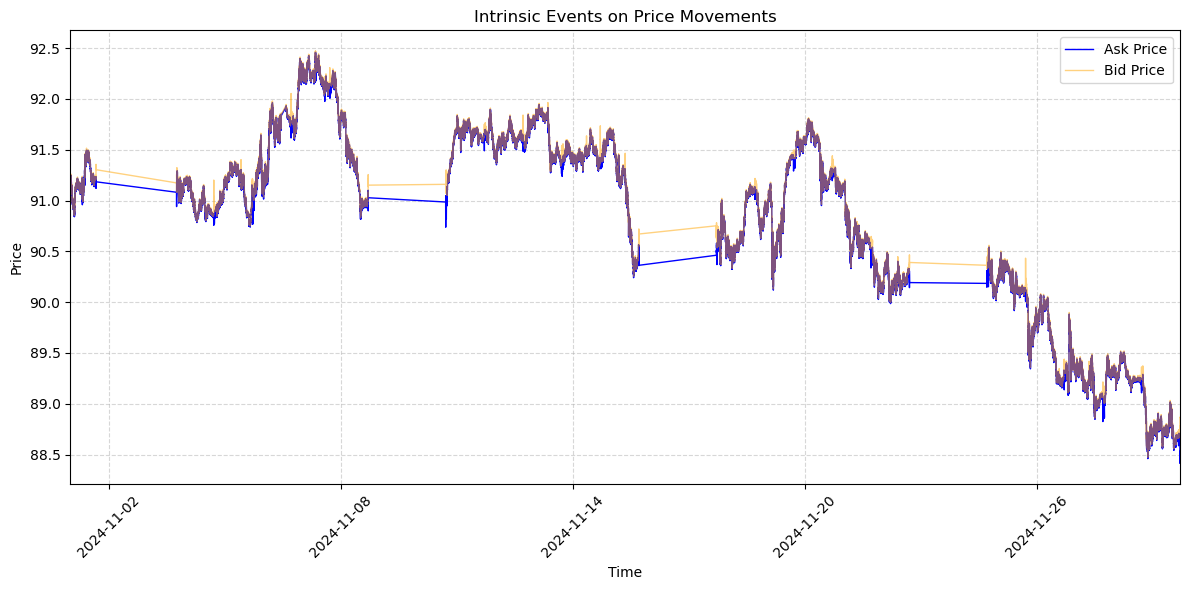

In [62]:
# Visualize the intrinsic events
visualize_intrinsic_events(nzd_jpy_df, events)

In [63]:
# Backtest the trading strategy
performance = backtest_trading_strategy(nzd_jpy_df, events)
print("Trading Strategy Performance:")
for metric, value in performance.items():
    print(f"{metric}: {value}")

Trading Strategy Performance:
Total Trades: 5951
Total Wins: 5852
Total Losses: 98
Win Ratio: 0.9833641404805915
Largest Win (%): 0.7300719043627774
Largest Loss (%): -0.8967199783139044
Shortest Hold (ms): 50.0
Longest Hold (ms): 180002441.0
Total Cumulative Return (%): 799.7792826650681


-------

# **<span style="color:blue">Part II: Testing your strategy</span>** <a id="Part-2"></a>

-------

# **<span style="color:blue">Results and Discussion</span>** <a id="RnD"></a>

-------

# **<span style="color:blue">Conclusion</span>** <a id="Conclusion"></a>

-------

# **<span style="color:blue">References</span>** <a id="References"></a>